In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [2]:
import pandas as pd

df = pd.read_csv("./train.csv")

print("Missing values per column:")
print(df.isnull().sum())

# This is the attempt to replace the odd unicode characters with something else, but it doesnt seem to work yet
df["comment_text"] = df["comment_text"].str.replace("\n", " ")

df_cleaned = df.dropna()

X_train, X_test, y_train, y_test = train_test_split(df_cleaned["comment_text"], df["toxic"], test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# No longer using this
#df_cleaned.to_csv("cleaned_train.csv", index=False)

Missing values per column:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


**Train Loop**

In [3]:
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)

max_length = 500
X_train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
X_val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")
X_test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_length))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train_padded, y_train, epochs=4, batch_size=32, validation_data=(X_val_padded, y_val))

test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

# Print model summary
model.summary()

c:\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/4
 154/3192 ━━━━━━━━━━━━━━━━━━━━ 9:18 184ms/step - accuracy: 0.8729 - loss: 0.3681

KeyboardInterrupt: 

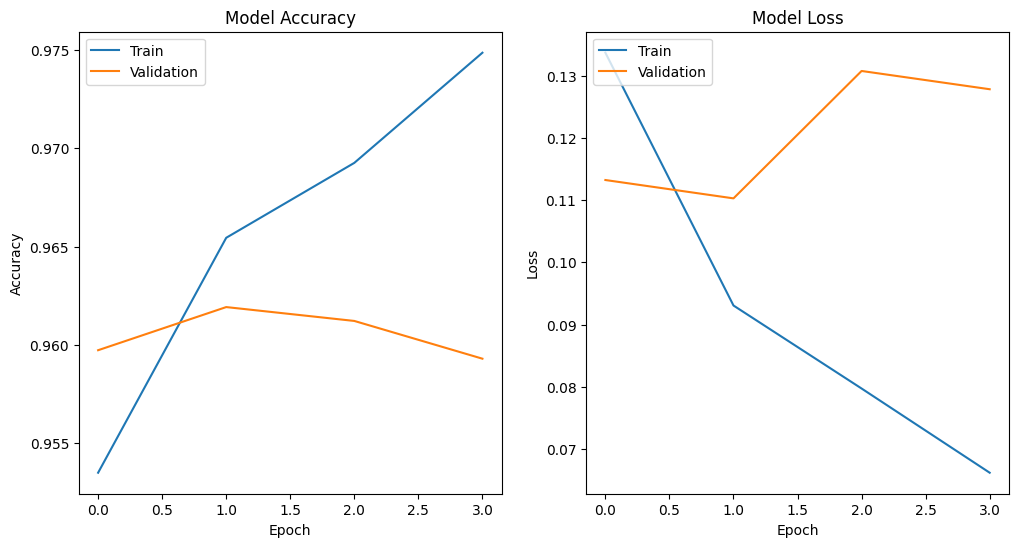

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [12]:
model.save("toxic_comment_rnn_model.keras")